In [1]:
import pandas as pd
import datetime as dt

# Pretty plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12

# Pandas settings
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100

# Project imports 
from self_harm_triage_notes.config import interim_data_dir, results_dir

# Toolbox imports
from ml_health_toolbox.dataset_utils import get_categorical_dtype, make_categorical

___
# RMH ED presentations

In [2]:
# Load data
rmh = pd.read_parquet(interim_data_dir / "rmh_2012_2022.parquet", engine="pyarrow")
rmh = rmh[rmh.year < 2022].copy()
rmh

,uid,sex,age,arrival_mode,arrival_date,year,triage_note,SH,SI,AOD_OD,SI_or_SH,audit_case,source_system
0,RMH-1,Female,64.0,Other,2012-01-08 00:35:00,2012,"SOB for 5/7, been to GP given prednisolone, coughing taken inhalers with minimal relief, speakin...",Not self-harm,Not suicidal ideation,Not overdose,0,NaN,Symphony
1,RMH-2,Male,31.0,Other,2012-01-08 00:41:00,2012,"pt has lac down right forehead, to eyebrow, will require stitches and ADT, denies loc wound abou...",Not self-harm,Not suicidal ideation,Not overdose,0,NaN,Symphony
2,RMH-3,Male,19.0,Road Ambulance Service,2012-01-08 00:52:00,2012,"pt expect MBA, trapped for 45mins, #right femur, had 40mg morphine, GCS 15",Not self-harm,Not suicidal ideation,Not overdose,0,NaN,Symphony
3,RMH-4,Male,51.0,Other,2012-01-08 01:11:00,2012,L) sided flank pain same as previous renal colic pain unimproved with analgesia for the past 1/5...,Not self-harm,Not suicidal ideation,Not overdose,0,NaN,Symphony
4,RMH-5,Female,25.0,Other,2012-01-08 01:23:00,2012,generalised abdo pain and associated headache for 1 year worse tonight. Pt states that she had ...,Not self-harm,Not suicidal ideation,Not overdose,0,NaN,Symphony
...,...,...,...,...,...,...,...,...,...,...,...,...,...
728950,RMH-2021-83267,F,50.0,Helicopter,2021-12-31 22:28:49,2021,"HEMS. 11:30 kayaking on river, fell out, landed on rock on L) side. Went home. Called ambulance...",Not self-harm,Not suicidal ideation,Not overdose,0,0.0,EPIC
728951,RMH-2021-83268,F,65.0,Road Ambulance,2021-12-31 22:41:06,2021,Direct admit under DFU. Infected L toe. Hx DM,Not self-harm,Not suicidal ideation,Not overdose,0,0.0,EPIC
728952,RMH-2021-83269,F,35.0,Other,2021-12-31 23:21:01,2021,"Stung by bee at 1200hrs, increased redness and swelling localised to L) lower arm since, no reli...",Not self-harm,Not suicidal ideation,Not overdose,0,0.0,EPIC
728953,RMH-2021-83270,F,39.0,Road Ambulance,2021-12-31 23:28:14,2021,"Developed chest/arm pain yesterday, worse on movement. Today felt dizzy w/ palps. Hx anxiety. Re...",Not self-harm,Not suicidal ideation,Not overdose,0,0.0,EPIC


## General info

In [3]:
rmh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728955 entries, 0 to 728954
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   uid            728955 non-null  object        
 1   sex            728953 non-null  object        
 2   age            728955 non-null  float64       
 3   arrival_mode   728947 non-null  object        
 4   arrival_date   728955 non-null  datetime64[ns]
 5   year           728955 non-null  int64         
 6   triage_note    722875 non-null  object        
 7   SH             728955 non-null  category      
 8   SI             728955 non-null  category      
 9   AOD_OD         728955 non-null  category      
 10  SI_or_SH       728955 non-null  int64         
 11  audit_case     173041 non-null  float64       
 12  source_system  728955 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 63.3+ MB


In [4]:
rmh.isna().sum()

uid                   0
sex                   2
age                   0
arrival_mode          8
arrival_date          0
year                  0
triage_note        6080
SH                    0
SI                    0
AOD_OD                0
SI_or_SH              0
audit_case       555914
source_system         0
dtype: int64

In [5]:
rmh.nunique()

uid              728955
sex                  13
age                 119
arrival_mode         99
arrival_date     699451
year                 10
triage_note      721068
SH                    2
SI                    2
AOD_OD                2
SI_or_SH              2
audit_case            2
source_system         2
dtype: int64

## Data checks

In [6]:
# Check the year was extracted correctly
assert (rmh.arrival_date.dt.year == rmh.year).all()

In [7]:
# # Fix triage date errors
# print("Triage date is before 01.01.2012 in %d presentations, replace with arrival date" % 
#       (rmh.triage_date < pd.Timestamp(2012,1,1)).sum())
# rmh.loc[rmh.triage_date < pd.Timestamp(2012,1,1), 'triage_date'] = rmh.loc[rmh.triage_date < pd.Timestamp(2012,1,1), 
#                                                                         'arrival_date']

# # Triage date before Arrival date
# print("For %d presentations triage was before arrival." % 
#       (rmh.triage_date < rmh.arrival_date).sum())
# # Triage date should not be much earlier than Arrival date
# print("Out of those, %d presentations have triage date more than 24 hours before arrival." % 
#       ((rmh.triage_date - rmh.arrival_date).dt.days < -1).sum())

# # Triage date more than a day after the Arrival date
# print("For %d presentations the triage date is more than 24 hours after the arrival date." % 
#       ((rmh.triage_date - rmh.arrival_date).dt.days > 0).sum())

In [8]:
# Empty triage notes
print("The dataset contains %d presentations with empty triage notes." % 
      rmh.triage_note.isna().sum())
# Triage note containing only "\n"
print("The dataset contains %d presentations containing only newline." % 
      (rmh.triage_note.str.lower()==" \n").sum())
# Triage note stating "as above"
print("The dataset contains %d presentations stating \"as above\"." % 
      (rmh.triage_note.str.lower()=="as above").sum())

The dataset contains 6080 presentations with empty triage notes.
The dataset contains 0 presentations containing only newline.
The dataset contains 46 presentations stating "as above".


### Number of presentations over time

In [9]:
# Expected range of dates
count_per_day = pd.DataFrame(index=pd.date_range(start='2012-01-01',end='2022-06-30'))
count_per_day['count'] = 0
# Update with actual counts
count_per_day.update({'count': rmh.groupby(rmh.arrival_date.dt.date).size()})

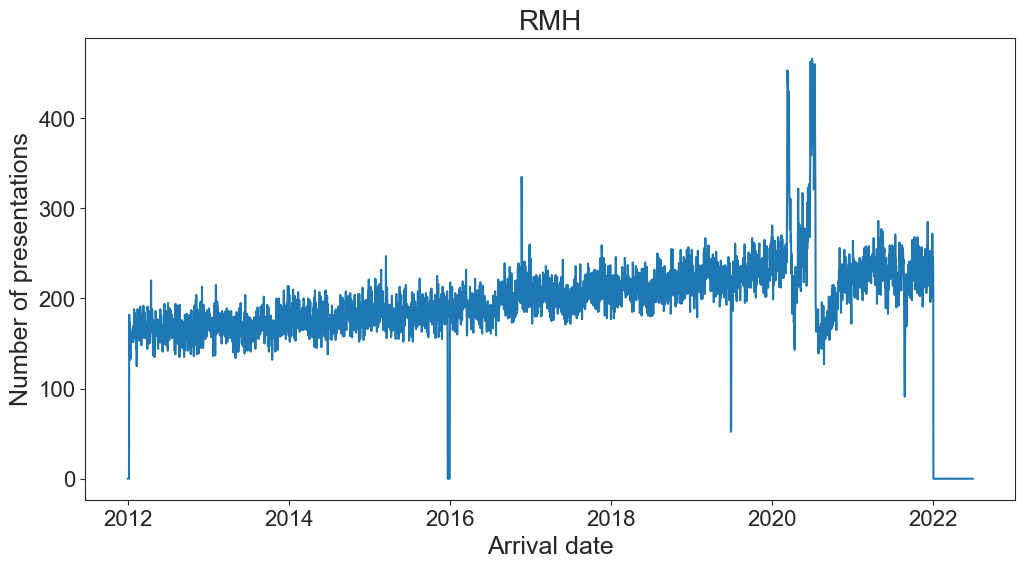

In [10]:
plt.rcParams['figure.figsize'] = (12, 6)

sns.lineplot(x=count_per_day.index,
             y=count_per_day['count']);

plt.xlabel("Arrival date");
plt.ylabel("Number of presentations");
plt.title("RMH");
plt.savefig("../results/RMH number of presentations.jpeg", dpi=300, pad_inches=0);

In [11]:
rmh.arrival_date.dt.date.value_counts().tail(10)

arrival_date
2012-01-14    133
2013-10-17    132
2012-01-12    132
2020-08-23    127
2012-02-11    125
2021-08-23    123
2021-08-24     91
2019-06-29     55
2019-06-28     52
2015-12-31      1
Name: count, dtype: int64

In [12]:
# Data missing between 22 Dec 2015 and 31 Dec 2015 inclusive
rmh[(rmh.arrival_date.dt.date >= dt.date(2015, 12, 15)) & 
   (rmh.arrival_date.dt.date <= dt.date(2016, 1, 5))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2015-12-15    189
2015-12-16    195
2015-12-17    190
2015-12-18    172
2015-12-19    208
2015-12-20    179
2015-12-21    198
2015-12-31      1
2016-01-01    206
2016-01-02    218
2016-01-03    187
2016-01-04    207
2016-01-05    202
Name: count, dtype: int64

In [13]:
# Lower than usual number of cases on 28-29 Jun 2019
rmh[(rmh.arrival_date.dt.date >= dt.date(2019, 6, 25)) & 
   (rmh.arrival_date.dt.date <= dt.date(2019, 7, 5))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2019-06-25    220
2019-06-26    209
2019-06-27    226
2019-06-28     52
2019-06-29     55
2019-06-30    206
2019-07-01    215
2019-07-02    224
2019-07-03    211
2019-07-04    218
2019-07-05    222
Name: count, dtype: int64

In [14]:
# Lower than usual number of cases on 24 Aug 2021
rmh[(rmh.arrival_date.dt.date >= dt.date(2021, 8, 20)) & 
   (rmh.arrival_date.dt.date <= dt.date(2021, 8, 30))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2021-08-20    229
2021-08-21    188
2021-08-22    146
2021-08-23    123
2021-08-24     91
2021-08-25    143
2021-08-26    162
2021-08-27    184
2021-08-28    204
2021-08-29    188
2021-08-30    227
Name: count, dtype: int64

In [15]:
rmh.arrival_date.dt.date.value_counts().head(10)

arrival_date
2020-06-30    466
2020-06-23    463
2020-07-11    460
2020-03-10    453
2020-03-13    450
2020-03-12    443
2020-07-01    443
2020-03-11    439
2020-07-07    436
2020-06-29    434
Name: count, dtype: int64

In [16]:
# Higher than usual number of cases on 21 Nov 2016
rmh[(rmh.arrival_date.dt.date >= dt.date(2016, 11, 15)) & 
   (rmh.arrival_date.dt.date <= dt.date(2016, 11, 30))].arrival_date.dt.date.value_counts().sort_index()

arrival_date
2016-11-15    208
2016-11-16    195
2016-11-17    210
2016-11-18    204
2016-11-19    220
2016-11-20    211
2016-11-21    335
2016-11-22    308
2016-11-23    238
2016-11-24    205
2016-11-25    226
2016-11-26    188
2016-11-27    240
2016-11-28    211
2016-11-29    192
2016-11-30    196
Name: count, dtype: int64

In [17]:
count_per_day[count_per_day['count'] >= 400]

,count
2020-03-10,453
2020-03-11,439
2020-03-12,443
2020-03-13,450
2020-03-16,430
2020-03-17,402
2020-06-23,463
2020-06-24,414
2020-06-29,434
2020-06-30,466


### Annotations

In [18]:
# Check for confusion between SH, SI, and AOD OD
print("Number of presentations annotated as both SH and SI:", ((rmh.SH.cat.codes==1) & (rmh.SI.cat.codes==1)).sum())
print("Number of presentations annotated as both SH and AOD OD:", ((rmh.SH.cat.codes==1) & (rmh.AOD_OD.cat.codes==1)).sum())
print("Number of presentations annotated as both SI and AOD OD:", ((rmh.SI.cat.codes==1) & (rmh.AOD_OD.cat.codes==1)).sum())

Number of presentations annotated as both SH and SI: 0
Number of presentations annotated as both SH and AOD OD: 1
Number of presentations annotated as both SI and AOD OD: 16


In [19]:
# Patients under the age of 9 with positive labels
print("Number of presentation annotated as SH from patients under the age of 9:", ((rmh.SH.cat.codes==1) & (rmh.age<9)).sum())
print("Number of presentation annotated as SI from patients under the age of 9:", ((rmh.SI.cat.codes==1) & (rmh.age<9)).sum())
print("Number of presentation annotated as AOD from patients under the age of 9:", ((rmh.AOD_OD.cat.codes==1) & (rmh.age<9)).sum())

Number of presentation annotated as SH from patients under the age of 9: 1
Number of presentation annotated as SI from patients under the age of 9: 0
Number of presentation annotated as AOD from patients under the age of 9: 1


## Normalise data

### Sex

In [20]:
rmh.sex.value_counts(dropna=False)

sex
Male                 261774
Female               235568
M                    108651
F                    103327
1 - Male               9956
2 - Female             9461
R                       111
Intersex                 97
3 - Indeterminate         3
Indeterminate             2
None                      2
Not Specified             1
 - Unidentified           1
4 - Other                 1
Name: count, dtype: int64

In [21]:
# Normalise sex variable to 4 values (RMH)
rmh.loc[rmh.sex.isin(["Female", "F", "2 - Female"]), 'sex'] = "female"
rmh.loc[rmh.sex.isin(["Male", "M", "1 - Male"]), 'sex'] = "male"
rmh.loc[rmh.sex.isin(["Intersex", "R", "3 - Indeterminate", "Indeterminate"]), 'sex'] = "intersex"
rmh.loc[~rmh.sex.isin(["female", "male", "intersex"]), 'sex'] = "unknown"

categories = ["female", "male", "intersex", "unknown"]
categorical_dtype, _ = get_categorical_dtype(categories=categories)
rmh.sex = make_categorical(rmh.sex, categorical_dtype)

### Arrival method

In [22]:
rmh.arrival_mode.nunique()

99

In [23]:
rmh.arrival_mode.value_counts(dropna=False).head(15)

arrival_mode
Other                                                                         285822
Road Ambulance Service                                                        170995
Self-presented/Community/Public Transport                                     156834
Road Ambulance                                                                 76811
6 - Community/public transport (includes council / philanthropic services)     12131
3 - Road Ambulance Service                                                      6799
Private Ambulance - Contracted by  AV/RAV                                       4137
Police                                                                          3634
Helicopter                                                                      3423
Private Ambulance - AV contracted                                               2406
 Private Ambulance - Contracted by  AV/RAV                                      1552
Police Vehicle                                      

In [24]:
def normalise_arrival_mode(x):
    # Convert to lowercase
    x = x.str.lower()
    # Replace string values
    x.loc[x.fillna("").str.contains("community|self|walk-in|walked|public transport")] = "self/community/pt"
    x.loc[x.fillna("").str.contains("road ambulance")] = "road ambulance"
    x.loc[x.fillna("").str.contains("private|priv")] = "private ambulance"
    x.loc[x.fillna("").str.contains("air|helicopter")] = "air ambulance"
    x.loc[x.fillna("").str.contains("police")] = "police"
    x.loc[x.fillna("").str.contains("undertaker")] = "undertaker"
    x.loc[x.fillna("").str.contains("other")] = "other"
    
    categories = ['self/community/pt', 'road ambulance', 'private ambulance', 'air ambulance', 'police', 'undertaker', 'other']
    categorical_dtype, _ = get_categorical_dtype(categories=categories)
    x = make_categorical(x, categorical_dtype)
    
    return x

# Normalise arrival method variable
rmh.arrival_mode = normalise_arrival_mode(rmh.arrival_mode)

### Triage notes

In [25]:
# Fill missing value with empty string
rmh.fillna({'triage_note': ""}, inplace=True)

### Annotations

In [26]:
rmh.SH.cat.categories, rmh.SI.cat.categories, rmh.AOD_OD.cat.categories

(Index(['Not self-harm', 'Self-harm'], dtype='object'),
 Index(['Not suicidal ideation', 'Suicidal ideation'], dtype='object'),
 Index(['Not overdose', 'Overdose'], dtype='object'))

In [27]:
# Fix annotation errors
# One record annotated as both self-harm and AOD overdose
rmh.loc[(rmh.SH.cat.codes==1) & (rmh.AOD_OD.cat.codes==1), 'AOD_OD'] = "Not overdose"

# 16 records annotated as both suicidal ideation and AOD overdose
rmh.loc[(rmh.SI.cat.codes==1) & (rmh.AOD_OD.cat.codes==1), 'SI'] = "Not suicidal ideation"

# Patient aged 2 positive for SH
rmh.loc[(rmh.age==2) & (rmh.SH.cat.codes==1), 'SH'] = "Not self-harm"

# Patient aged 7 positive for AOD
rmh.loc[(rmh.age==7) & (rmh.AOD_OD.cat.codes==1), 'AOD_OD'] = "Not overdose"

# Two records annotated as both self-harm and suicidal ideation
rmh.loc[(rmh.SH.cat.codes==1) & (rmh.SI.cat.codes==1), 'SI'] = "Not suicidal ideation"

### Additional columns

In [28]:
# Create new column that contains quarter
rmh['quarter'] = rmh.arrival_date.dt.to_period('Q')

# Triage note length
rmh['length'] = rmh.triage_note.apply(len)

### Remove patients below the age of 9

In [30]:
# Remove presentations of patients under the age of 9
print("Removing %d presentations of patients under the age of 9." % (rmh.age < 9).sum())
rmh = rmh[rmh.age >= 9].copy()
rmh.reset_index(drop=True, inplace=True)
rmh.shape

Removing 189 presentations of patients under the age of 9.


(728766, 15)

## Stats

### Number of presentations per year

In [29]:
rmh.year.value_counts().sort_index().agg(['mean', 'std'])

mean    72895.500000
std      9525.538996
Name: count, dtype: float64

### Age

In [39]:
rmh.age.median(), rmh.age.mean(), rmh.age.std()

(44.0, 47.99839042984991, 21.4477496497756)

### Missing data

In [31]:
rmh.isna().sum()

uid                   0
sex                   0
age                   0
arrival_mode          9
arrival_date          0
year                  0
triage_note           0
SH                    0
SI                    0
AOD_OD                0
SI_or_SH              0
audit_case       555769
source_system         0
quarter               0
length                0
dtype: int64

In [32]:
rmh.sex.value_counts(dropna=False)

sex
male        380290
female      348258
intersex       213
unknown          5
Name: count, dtype: int64

In [33]:
rmh.arrival_mode.value_counts(dropna=False)

arrival_mode
other                285781
road ambulance       254617
self/community/pt    169494
private ambulance      9635
police                 4803
air ambulance          4146
undertaker              281
NaN                       9
Name: count, dtype: int64

### Length

In [37]:
(rmh.triage_note=="").sum()

6072

In [38]:
rmh.length.agg(['mean', 'std'])

mean    130.109062
std      55.752804
Name: length, dtype: float64

### Save dataset

In [ ]:
rmh.to_parquet(interim_data_dir / "rmh_2012_2022_cleaned.parquet", engine="pyarrow")

___
# EDA

In [ ]:
# Remove 2022 (temporarily)
rmh = rmh[rmh.year < 2022].copy()
rmh.shape

### Number of presentations

**Per year**

In [ ]:
palette = {year: sns.color_palette('Blues', 10)[4] for year in range(2012, 2018)}
palette.update({year: sns.color_palette('Blues', 10)[2] for year in range(2018, 2022)})

sns.countplot(x='year', data=rmh, hue='year', palette=palette, legend=False);
plt.xlabel("Arrival date");
plt.ylabel("ED presentations");
plt.title("RMH");
plt.savefig(results_dir / "RMH presentations per year.jpeg", bbox_inches='tight', dpi=300);

In [ ]:
rmh.year.value_counts().agg(['mean', 'std']).round()

**Per quarter**

In [ ]:
rmh.quarter.value_counts().agg(['mean', 'std']).round()

### Age

In [ ]:
rmh.age.describe().round()

In [ ]:
sns.kdeplot(x='age', data=rmh, fill=True);

### Sex

In [ ]:
rmh.sex.value_counts(normalize=True)

### Arrival method

In [ ]:
rmh.arrival_mode.value_counts(normalize=True)

### Length of triage notes

In [ ]:
rmh.length.describe().round()

### SH and SI

In [ ]:
(rmh.SH.value_counts(dropna=False, normalize=True) * 100).round(1)

In [ ]:
(rmh.SI.value_counts(dropna=False, normalize=True) * 100).round(1)